# Ejemplos de modelos bayesianos para recordar y repasar PYMC con ayuda de ChatGPT

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pytensor  


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 0 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

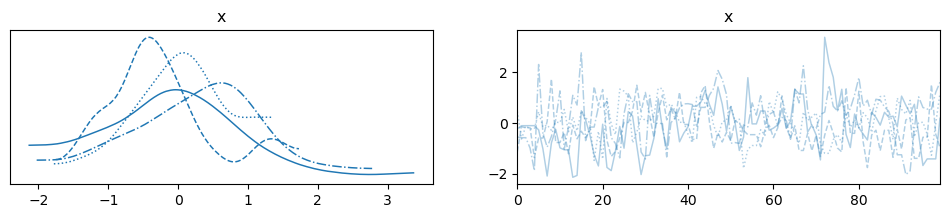

In [ ]:
# PRUEBA a ver si funciona el entorno de PyMC3 y ArviZ
warnings.filterwarnings("ignore")

with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    trace = pm.sample(100, tune=100, progressbar=False)

az.plot_trace(trace)


---

# Flujo bayesiano:

1. Planteamiento del modelo (modelo generativo)
2. Elección de las distribuciones previas (priors)
3. Construcción del modelo en PyMC
4. Inferencia bayesiana (posterior) con MCMC
5. Chequeo del modelo (posterior predictive checks)
6. Predicción / visualización / interpretación

## 🎯 Problema

Queremos estimar la tasa de éxito ($\theta$) de una campaña donde se enviaron mensajes a 100 personas y 30 respondieron positivamente.

---

## 🧠 Modelo generativo bayesiano

Definimos un modelo simple donde:

- $y$ es el número de respuestas positivas observadas
- $n$ es el número total de intentos (100 en este caso)
- $\theta$ es la verdadera (desconocida) probabilidad de éxito

### Distribución previa (prior)

Usamos una distribución Beta no informativa:

$$
\theta \sim \mathrm{Beta}(1, 1)
$$

Esto refleja que **a priori** todos los valores entre 0 y 1 son igualmente probables.

Aunque `Beta(1,1)` y `Uniform(0,1)` son equivalentes en forma (ambas distribuyen probabilidad de manera uniforme entre 0 y 1), usamos `Beta(1,1)` en modelos bayesianos porque es conjugada con la distribución binomial, lo que permite una inferencia más eficiente, es más estable numéricamente para los algoritmos de muestreo como MCMC, y se puede ajustar fácilmente para incorporar conocimiento previo si se desea.

---

### Likelihood (verosimilitud)

La observación $y$ sigue una distribución binomial, condicionada a $\theta$:

$$
y \sim \mathrm{Binomial}(n=100, p=\theta)
$$

---

## 📦 Modelo completo

$$
\begin{aligned}
\theta &\sim \mathrm{Beta}(1, 1) \\\\
y &\sim \mathrm{Binomial}(n=100, p=\theta)
\end{aligned}
$$

---

Este modelo nos permite actualizar nuestra creencia sobre $\theta$ después de observar los datos $y = 30$.



In [4]:
# Datos observados
y_obs = 30                      # Número de éxitos observados
n_total = 100                  # Número total de intentos

# Definimos el modelo probabilístico
with pm.Model() as modelo:
    
    # 1️⃣ Prior: creencia inicial sobre la probabilidad de éxito θ
    theta = pm.Beta("theta", alpha=1, beta=1)

    # 2️⃣ Likelihood (verosimilitud): cómo se generan los datos dado θ
    # Los datos y_obs se distribuyen Binomial(n=100, p=θ)
    # observed=y_obs conecta los datos al modelo
    y = pm.Binomial("y", n=n_total, p=theta, observed=y_obs)

    # 3️⃣ Inference: muestreamos desde la posterior con MCMC (por defecto usa NUTS)
    # return_inferencedata=True devuelve un objeto compatible con ArviZ
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


array([[<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

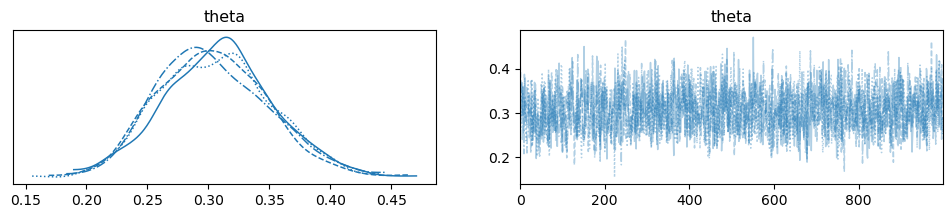

In [5]:
# 📊 Graficamos las cadenas MCMC y distribuciones posteriores
az.plot_trace(trace)


In [6]:
# 📈 Mostramos estadísticas resumen para cada parámetro muestreado
az.summary(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.306,0.045,0.223,0.39,0.001,0.001,1625.0,2658.0,1.0


---

In [9]:
# ¿Afecta el nivel socioeconómico (NSE) y edad la probabilidad de tener seguro médico?

# Simulación de datos
np.random.seed(123)

n = 500

edad = np.random.randint(18, 70, n)  # adultos
nse = np.random.randint(1, 6, n)     # de 1 a 5

# Simulamos una relación creíble:
# - A mayor edad, más probabilidad de tener seguro
# - A mayor NSE, también
logit_p = -3 + 0.05 * edad + 0.6 * nse
p = 1 / (1 + np.exp(-logit_p))

seguro = np.random.binomial(1, p)

df = pd.DataFrame({
    "edad": edad,
    "nse": nse,
    "seguro": seguro
})


In [ ]:
# definir modelo en pymc 

with pm.Model() as modelo:

    # 1️⃣ PRIORS: creencias sobre los parámetros antes de ver los datos
    beta_0 = pm.Normal("beta_0", mu=0, sigma=5)   # Intercepto
    beta_1 = pm.Normal("beta_1", mu=0, sigma=1)   # Coef. para edad
    beta_2 = pm.Normal("beta_2", mu=0, sigma=1)   # Coef. para NSE

    # 2️⃣ MODELO DETERMINÍSTICO: regla que transforma entrada en probabilidad
    logit_p = beta_0 + beta_1 * df["edad"] + beta_2 * df["nse"]
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))  # Función logística

    # 3️⃣ VEROSIMILITUD: los datos observados provienen de una Bernoulli con probabilidad p
    y = pm.Bernoulli("y", p=p, observed=df["seguro"])


In [13]:
with modelo:
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [14]:
az.summary(trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-1.898,0.402,-2.725,-1.157,0.011,0.008,1456.0,1546.0,1.0
beta_1,0.030,0.007,0.015,0.044,0.000,0.000,1520.0,1646.0,1.0
beta_2,0.579,0.083,0.408,0.732,0.002,0.002,1771.0,1550.0,1.0
p[0],0.848,0.026,0.797,0.899,0.001,0.000,1998.0,2015.0,1.0
p[1],0.607,0.044,0.518,0.691,0.001,0.001,1919.0,2162.0,1.0
...,...,...,...,...,...,...,...,...,...
p[495],0.568,0.044,0.482,0.652,0.001,0.001,2533.0,2797.0,1.0
p[496],0.597,0.046,0.508,0.688,0.001,0.001,2517.0,2717.0,1.0
p[497],0.850,0.021,0.810,0.892,0.000,0.000,2354.0,2563.0,1.0
p[498],0.832,0.025,0.785,0.882,0.001,0.000,2140.0,2081.0,1.0


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta_1'}>,
        <Axes: title={'center': 'beta_1'}>],
       [<Axes: title={'center': 'beta_2'}>,
        <Axes: title={'center': 'beta_2'}>],
       [<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

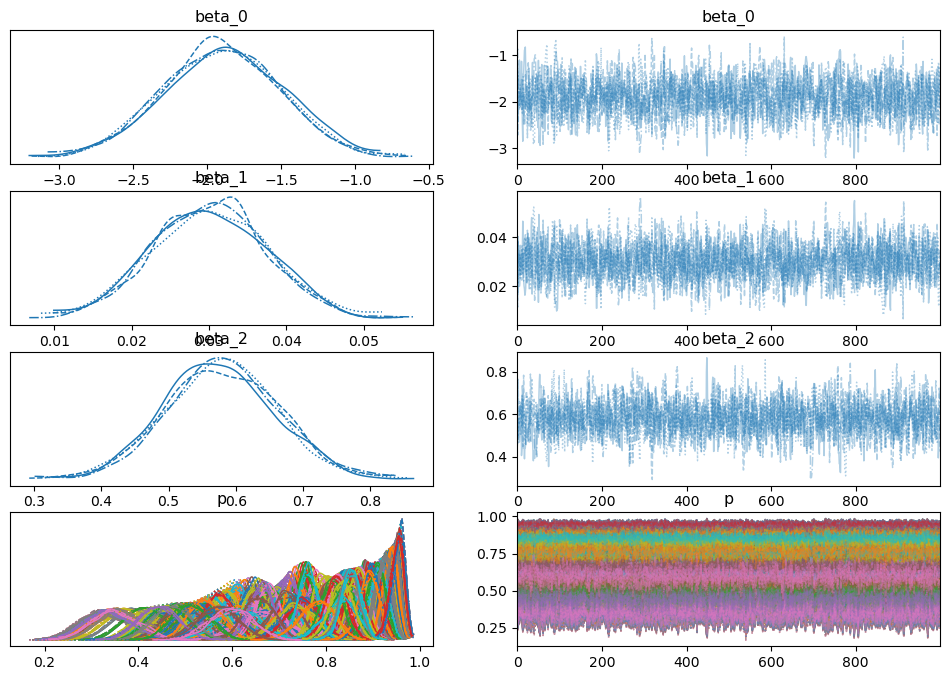

In [15]:
az.plot_trace(trace)


---

In [17]:
# Hay diferencia en la presión arterial promedio entre grupo A (tratamiento) y grupo B (placebo)?

# Datos simulados
# Simulamos los datos reales fuera del modelo
np.random.seed(42)

grupo_A_obs = np.random.normal(loc=120, scale=10, size=50)  # Grupo A: tratamiento
grupo_B_obs = np.random.normal(loc=125, scale=10, size=50)  # Grupo B: placebo

# 1 = grupo B (placebo), 0 = grupo A (tratamiento)
datos = np.concatenate([grupo_A_obs, grupo_B_obs])
grupo = np.concatenate([np.zeros(50), np.ones(50)])

In [18]:
with pm.Model() as modelo:

    # Priors para las medias de cada grupo
    mu_A = pm.Normal("mu_A", mu=100, sigma=20)
    mu_B = pm.Normal("mu_B", mu=100, sigma=20)

    # Prior compartido para sigma (se asume igual para ambos)
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Media condicional: si grupo=0 usa mu_A, si grupo=1 usa mu_B
    mu = pm.math.switch(grupo, mu_B, mu_A)

    # Likelihood: los datos observados vienen de una Normal
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=datos)

    # Inference
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

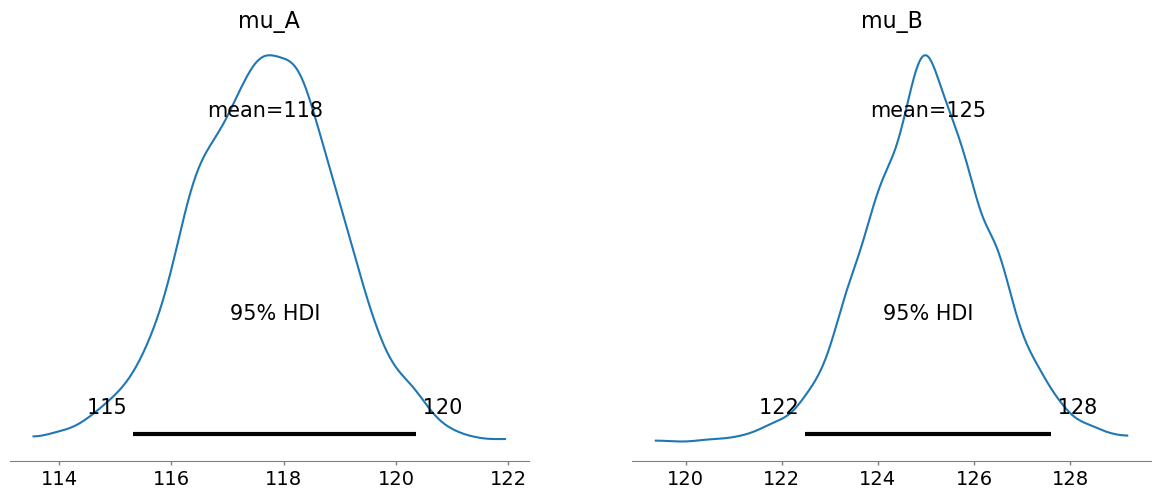

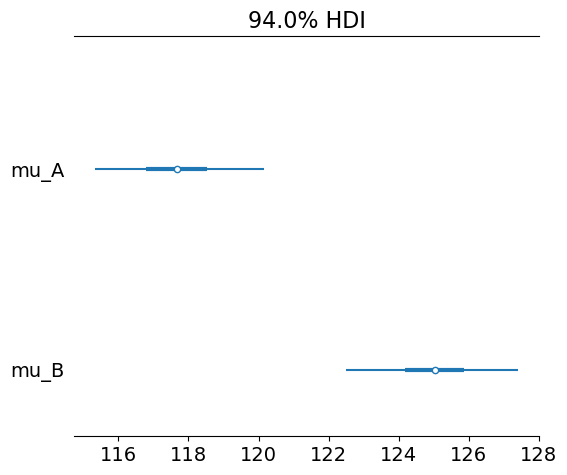

In [19]:
az.plot_posterior(trace, var_names=["mu_A", "mu_B"], hdi_prob=0.95)
az.plot_forest(trace, var_names=["mu_A", "mu_B"], combined=True)


---

#### Modelo Jerárquico: ejemplo

Datos de calificaciones promedio de estudiantes de distintas escuelas (A, B, C...). Queremos:

- Estimar la media de cada escuela.

- Suponer que estas medias vienen de una distribución común (una “media de medias”).

In [20]:
# Simulamos datos 
np.random.seed(42)

n_escuelas = 5
n_estudiantes = 30

# Media real por escuela (desconocida)
mu_escuelas = np.random.normal(loc=70, scale=5, size=n_escuelas)

# Calificaciones por escuela
datos = []
for i in range(n_escuelas):
    calificaciones = np.random.normal(loc=mu_escuelas[i], scale=10, size=n_estudiantes)
    datos.extend([(i, nota) for nota in calificaciones])

df = pd.DataFrame(datos, columns=["escuela", "nota"])


In [21]:

with pm.Model() as modelo_jerarquico:
    
    # 1️⃣ Priors para la media general del sistema educativo
    # Suponemos que en promedio los estudiantes sacan 70 ± 10
    mu_gral = pm.Normal("mu_gral", mu=70, sigma=10)

    # 2️⃣ Priors para la variabilidad entre escuelas
    # Captura cuán diferentes pueden ser las medias de las escuelas
    sigma_gral = pm.HalfNormal("sigma_gral", sigma=10)  # Solo valores positivos

    # 3️⃣ Medias específicas por escuela (nivel intermedio del modelo jerárquico)
    # Cada escuela tiene su propia media, pero no es completamente libre:
    # está anclada a mu_gral y regulada por sigma_gral
    mu_escuela = pm.Normal("mu_escuela", mu=mu_gral, sigma=sigma_gral, shape=n_escuelas)

    # 4️⃣ Prior para la desviación estándar dentro de cada escuela
    # Representa la variabilidad entre estudiantes dentro de una misma escuela
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=10)

    # 5️⃣ Verosimilitud (likelihood): distribución de las notas observadas
    # Aquí conectamos los datos con el modelo
    # Para cada estudiante, usamos la media de su escuela correspondiente
    y = pm.Normal("y", 
                  mu=mu_escuela[df["escuela"].values],  # Vector indexado
                  sigma=sigma_obs, 
                  observed=df["nota"])  # Datos reales

    # 6️⃣ Inference: sampleo MCMC
    trace = pm.sample(1000, tune=1000, return_inferencedata=True, random_seed=42)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_gral, sigma_gral, mu_escuela, sigma_obs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
# Ver resumen de las estimaciones
az.summary(trace, var_names=["mu_gral", "sigma_gral", "sigma_obs", "mu_escuela"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_gral,71.240,2.658,66.145,76.339,0.044,0.055,3880.0,2408.0,1.0
sigma_gral,5.446,2.513,1.593,10.132,0.047,0.050,2424.0,1660.0,1.0
sigma_obs,9.437,0.555,8.479,10.595,0.008,0.010,4785.0,2441.0,1.0
mu_escuela[0],70.315,1.672,67.176,73.472,0.023,0.033,5308.0,2703.0,1.0
mu_escuela[1],67.624,1.687,64.549,70.840,0.025,0.029,4393.0,2640.0,1.0
mu_escuela[2],73.627,1.633,70.561,76.714,0.023,0.026,5038.0,3065.0,1.0
mu_escuela[3],76.864,1.726,73.873,80.344,0.028,0.030,3803.0,2101.0,1.0
mu_escuela[4],68.347,1.633,65.189,71.355,0.025,0.027,4348.0,2840.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

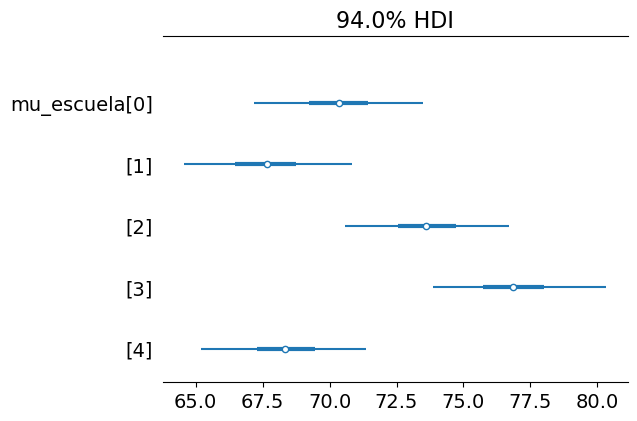

In [23]:
# Visualizar distribuciones posteriores
az.plot_forest(trace, var_names=["mu_escuela"], combined=True)


### Modelo Jerárquico simplificado para Growth Charts 

In [28]:
# Simulación de datos
# -----------------------------
# 🔁 Reproducibilidad
np.random.seed(42)

# -----------------------------
# 📦 Parámetros de la simulación
n_municipios = 10      # Número de grupos (municipios)
n_personas = 80        # Personas por municipio
n_total = n_municipios * n_personas

# -----------------------------
# 🏘 Grupo (municipio)
municipio = np.repeat(np.arange(n_municipios), n_personas)

# 📅 Edad entre 8 y 16 años
edad = np.random.uniform(8, 16, n_total)

# 👦👧 Sexo binario (0 = niña, 1 = niño)
sexo = np.random.binomial(1, 0.5, n_total)

# 📈 Tanner como función de la edad (ordinal entre 1 y 5)
tanner = np.clip((edad - 7).astype(int), 1, 5)

# -----------------------------
# 🎲 Efecto aleatorio por municipio
# Este valor desplaza hacia arriba o abajo la talla media del municipio
efecto_municipio = np.random.normal(loc=0, scale=3, size=n_municipios)

# -----------------------------
# 📏 Talla (generada con un modelo lineal + efecto aleatorio + ruido)
talla = (
    125 +                  # Intercepto base
    4.5 * edad +           # Crecimiento por año de edad
    3.0 * sexo +           # Niños más altos en promedio
    2.5 * tanner +         # Efecto del estadio puberal
    efecto_municipio[municipio] +        # Intercepto aleatorio por municipio
    np.random.normal(0, 4, size=n_total)  # Ruido individual
)

# -----------------------------
# 🧮 Dataset final
df = pd.DataFrame({
    "municipio": municipio,
    "edad": edad,
    "sexo": sexo,
    "tanner": tanner,
    "talla": talla
})


In [31]:
with pm.Model() as modelo_niveles:

    # Nivel 3 – Priors globales
    beta_0 = pm.Normal("beta_0", mu=125, sigma=10)         # Intercepto
    beta_edad = pm.Normal("beta_edad", mu=5, sigma=2)      # Edad
    beta_sexo = pm.Normal("beta_sexo", mu=3, sigma=2)      # Sexo
    beta_tanner = pm.Normal("beta_tanner", mu=2.5, sigma=1.5)  # Tanner
    sigma_grupo = pm.HalfNormal("sigma_grupo", sigma=5)    # Desviación grupo
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=5)        # Error individual

    # Nivel 2 – Efecto aleatorio por grupo (municipio)
    alpha_j = pm.Normal("alpha_j", mu=0, sigma=sigma_grupo, shape=n_municipios)

    # Nivel 1 – Media esperada por individuo i en grupo j
    mu_ij = (
        beta_0 +
        beta_edad * df["edad"] +
        beta_sexo * df["sexo"] +
        beta_tanner * df["tanner"] +
        alpha_j[df["municipio"]]
    )

    # Verosimilitud
    talla_obs = pm.Normal("talla_obs", mu=mu_ij, sigma=sigma_obs, observed=df["talla"])

    # Inferencia
    trace = pm.sample(1000, tune=1000, target_accept=0.9, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_edad, beta_sexo, beta_tanner, sigma_grupo, sigma_obs, alpha_j]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [32]:
az.summary(trace, var_names=["beta_0", "beta_edad", "beta_sexo", "beta_tanner", "sigma_obs", "sigma_grupo", "alpha_j"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,124.360,1.395,121.776,126.946,0.064,0.042,478.0,633.0,1.01
beta_edad,4.458,0.147,4.186,4.725,0.004,0.003,1104.0,1695.0,1.01
beta_sexo,2.865,0.279,2.308,3.355,0.006,0.005,2010.0,2396.0,1.00
beta_tanner,2.528,0.227,2.091,2.921,0.007,0.004,1188.0,1901.0,1.01
sigma_obs,3.991,0.103,3.804,4.184,0.002,0.002,2738.0,2450.0,1.00
sigma_grupo,2.560,0.723,1.460,3.890,0.027,0.035,931.0,789.0,1.00
alpha_j[0],-0.507,0.999,-2.365,1.316,0.054,0.064,426.0,352.0,1.02
alpha_j[1],-1.901,0.998,-3.775,-0.039,0.056,0.065,386.0,340.0,1.02
alpha_j[2],-0.084,0.999,-1.887,1.833,0.055,0.064,407.0,371.0,1.02
alpha_j[3],-2.257,1.003,-4.155,-0.452,0.055,0.066,407.0,312.0,1.02


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

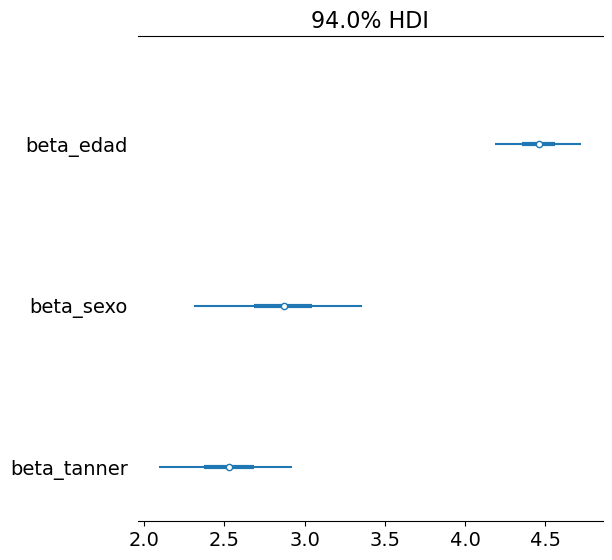

In [33]:
az.plot_forest(trace, var_names=["beta_edad", "beta_sexo", "beta_tanner"], combined=True)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

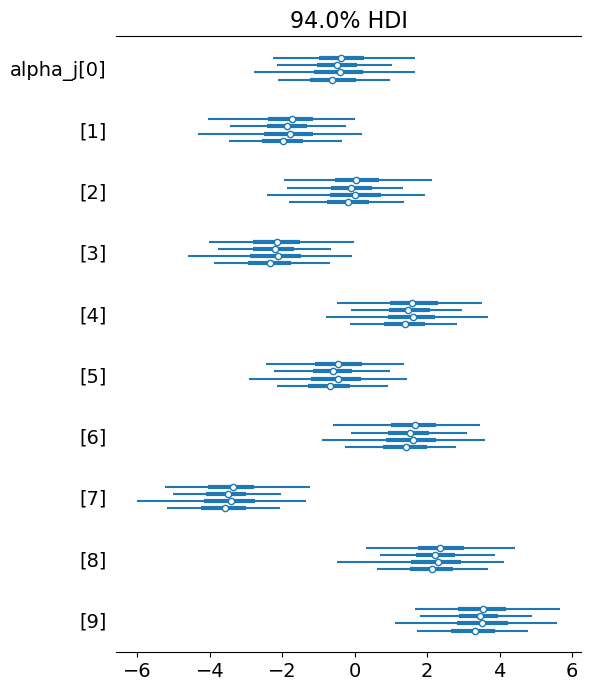

In [34]:
az.plot_forest(trace, var_names=["alpha_j"], combined=False)


In [ ]:
# Predicciones 

edad_new = 12
sexo_new = 1
tanner_new = 3
grupo_new = 4

# Extrae muestras de posterior predictiva
posterior_mu = (
    trace.posterior["beta_0"] +
    trace.posterior["beta_edad"] * edad_new +
    trace.posterior["beta_sexo"] * sexo_new +
    trace.posterior["beta_tanner"] * tanner_new +
    trace.posterior["alpha_j"].sel(alpha_j_dim_0=grupo_new)
)


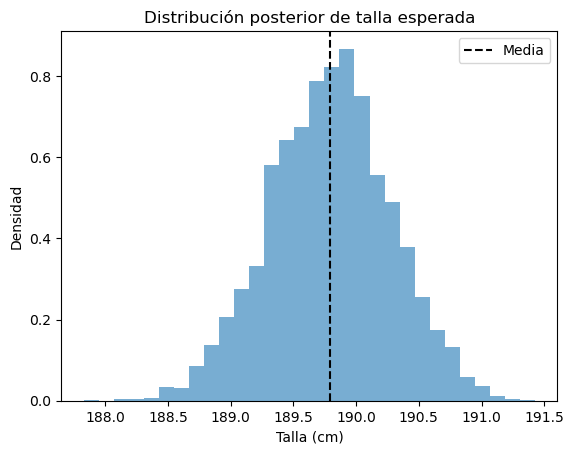

In [36]:
posterior_mu_values = posterior_mu.stack(samples=("chain", "draw")).values

plt.hist(posterior_mu_values, bins=30, density=True, alpha=0.6)
plt.axvline(np.mean(posterior_mu_values), color="black", linestyle="--", label="Media")
plt.title("Distribución posterior de talla esperada")
plt.xlabel("Talla (cm)")
plt.ylabel("Densidad")
plt.legend()
plt.show()


In [37]:
az.summary(posterior_mu, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,189.791,0.482,188.858,190.744,0.008,0.007,3975.0,3007.0,1.0


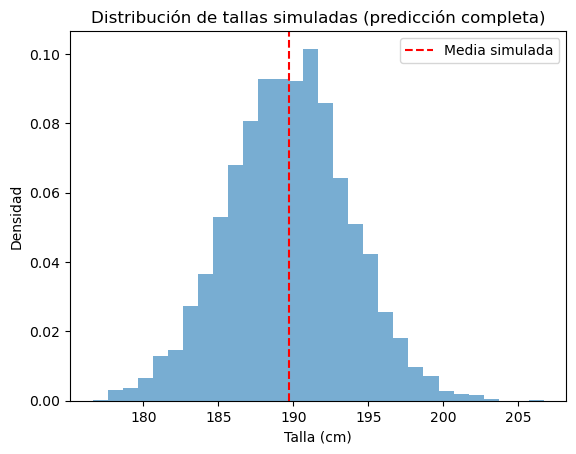

In [38]:
# Extrae sigma_obs
sigma_obs = trace.posterior["sigma_obs"].stack(samples=("chain", "draw")).values

# Simula tallas reales agregando error normal
talla_simulada = np.random.normal(loc=posterior_mu_values, scale=sigma_obs)

# Graficamos
plt.hist(talla_simulada, bins=30, density=True, alpha=0.6)
plt.axvline(np.mean(talla_simulada), color="red", linestyle="--", label="Media simulada")
plt.title("Distribución de tallas simuladas (predicción completa)")
plt.xlabel("Talla (cm)")
plt.ylabel("Densidad")
plt.legend()
plt.show()


#### Curvas de percentiles para hacerlo comparable a CDC 

In [39]:
# Creamos un rango continuo de edades (en años) entre 5 y 18, dividido en 100 puntos
# Esto será el eje X de nuestras curvas de crecimiento
edad_grid = np.linspace(5, 18, 100)  # 100 edades equiespaciadas de 5 a 18 años

# Fijamos valores de otras variables para condicionar las predicciones:
# sexo = 1 (niño), puedes cambiar a 0 para ver niñas
sexo_val = 1

# Fijamos un estadio puberal (Tanner) para el que queremos graficar
# Esto controla el ritmo de crecimiento esperado
tanner_val = 3  # Puede ir de 1 a 5

# Fijamos un grupo específico (por ejemplo, escuela o municipio)
# Esto nos permite ver las curvas para un grupo concreto
grupo_val = 0  # índice del grupo (0 a n_grupos-1)


In [40]:
# Combinamos las cadenas (chains) y las muestras (draws) en una sola dimensión
# Esto facilita trabajar con las muestras posteriores de forma vectorizada
posterior_samples = trace.posterior.stack(samples=("chain", "draw"))


In [41]:
# Creamos un diccionario vacío para almacenar los percentiles deseados:
# Percentil 3, 15, 50 (mediana), 85 y 97 — son los típicos en curvas CDC
percentiles = {p: [] for p in [3, 15, 50, 85, 97]}


In [42]:
# Iteramos sobre cada edad de la cuadrícula
for edad in edad_grid:

    # Calculamos la media (esperanza) de la talla predicha para esta edad
    # Usamos las muestras de la posterior de cada parámetro
    mu_pred = (
        posterior_samples["beta_0"] +                            # Intercepto
        posterior_samples["beta_edad"] * edad +                 # Efecto de la edad
        posterior_samples["beta_sexo"] * sexo_val +            # Efecto del sexo (niño o niña)
        posterior_samples["beta_tanner"] * tanner_val +        # Efecto del estadio puberal
        posterior_samples["alpha_j"].sel(alpha_j_dim_0=grupo_val)  # Efecto aleatorio del grupo
    ).values  # convertimos a array NumPy

    # Simulamos valores de talla añadiendo error (ruido) normal
    # La desviación estándar proviene de la distribución posterior de sigma_obs
    sigma = posterior_samples["sigma_obs"].values
    y_pred = np.random.normal(loc=mu_pred, scale=sigma)

    # Calculamos los percentiles deseados de las predicciones simuladas
    for p in percentiles.keys():
        percentiles[p].append(np.percentile(y_pred, p))


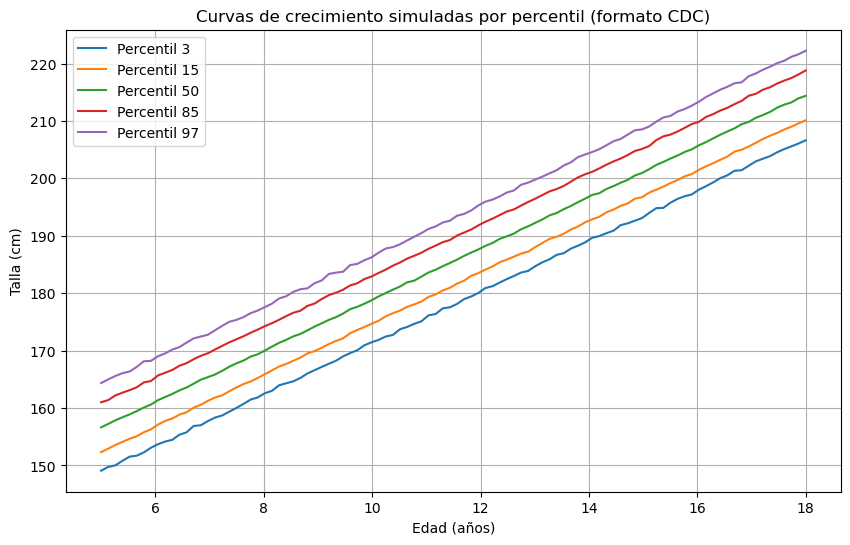

In [ ]:
# Creamos la figura de la gráfica
plt.figure(figsize=(10, 6))

# Graficamos cada curva de percentil en función de la edad
for p in percentiles:
    plt.plot(edad_grid, percentiles[p], label=f"Percentil {p}")

# Estética de la gráfica
plt.xlabel("Edad (años)")
plt.ylabel("Talla (cm)")
plt.title("Curvas de crecimiento simuladas por percentil (formato CDC)")
plt.legend()
plt.grid(True)
plt.show()
